# Golly - Pseudo Cup - Season 3


In [1]:
import os, sys, subprocess, json, time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

xkcd_colors = sns.xkcd_rgb
GOLLY_GRAY = "#272B30"
SEASON0 = 2

## Loading Match Data

Start by loading match data from the `data/` dir:

In [2]:
def run_cmd(cmd_str):
    child = subprocess.Popen(cmd_str, shell=True, stdout=subprocess.PIPE)
    output = child.communicate()[0].decode()
    return output

print(run_cmd('ls ../data/'))

clone.sh
gollyx-dragon-data
gollyx-hellmouth-data
gollyx-klein-data
gollyx-pseudo-data
gollyx-rainbow-data
gollyx-star-data
gollyx-toroidal-data



Here is what the entire contents of a given FULL season of Golly looks like: schedule data, regular season data (schedule data plus scores/outcomes), braket data, postseason data (bracket data plus scores/outcomes), and teams.

In [3]:
cup = 'pseudo'
print(run_cmd(f'ls ../data/gollyx-{cup}-data/season{SEASON0}'))

bracket.json
postseason.json
schedule.json
season.json
seed.json
teams.json



In [4]:
post_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{SEASON0}', 'postseason.json')

with open(post_file, 'r') as f:
    season0_post = json.load(f)

In [5]:
# this should have been PCS but we were too lazy to change it :)
pseudo_cup = season0_post['HCS']

In [6]:
last_day = pseudo_cup[-1]
last_game = last_day[0]

In [7]:
last_day = len(pseudo_cup)
print(last_day)

7


Each game consists of a JSON structure with the following keys:

In [8]:
pprint(list(last_game.keys()))

['team1Name',
 'team2Name',
 'team1Abbr',
 'team2Abbr',
 'description',
 'season',
 'gameid',
 'isPostseason',
 'map',
 'team1Score',
 'team2Score',
 'generations',
 'team1Color',
 'team2Color',
 'day',
 'team1PostseasonWinLoss',
 'team2PostseasonWinLoss',
 'team1SeriesWinLoss',
 'team2SeriesWinLoss']


The most important key is the `map` key, which contains JSON describing the grid and initial conditions for the match, which is what we need to actually simulate it:

In [9]:
pprint(list(last_game['map'].keys()))

['patternName',
 'mapName',
 'mapZone1Name',
 'mapZone2Name',
 'mapZone3Name',
 'mapZone4Name',
 'initialConditions1',
 'initialConditions2',
 'url',
 'rows',
 'columns',
 'cellSize']


Here, each of the `*Name` fields are arbitrary labels; the `url` field provides the same information as the initial conditions fields; and the `cellSize` field is used when drawing the grid. So the only fields that we really need to simulate the match are:

* `initialConditions{1,2}`
* `rows`
* `columns`

## Extracting Initial Conditions


All Pseudo Cup matches took place on a 100 x 120 grid:

In [10]:
print(last_game['map']['rows'])
print(last_game['map']['columns'])

100
120


In [11]:
print(json.loads(last_game['map']['initialConditions1']))

[{'40': [13, 16]}, {'41': [16]}, {'42': [14, 15]}, {'43': [15]}, {'45': [19]}, {'46': [19, 20]}, {'47': [18]}, {'48': [18, 21, 42]}, {'49': [41, 42]}, {'50': [30, 43]}, {'51': [30, 31, 40, 43]}, {'52': [29]}, {'53': [29, 32]}, {'55': [52, 55]}, {'56': [52]}, {'57': [53, 54]}, {'58': [53]}]


## Loading `gollyx-python`

Once we've loaded the initial list life dictionary and grid sizes from the Golly data directory, we can initialize a new `gollyx-python` simulator of that size, with the right corresponding birth/survival (B/S) rules for this cellular automata.

(That should be taken care of by using the right `GOL` or `CA` class from the `gollyx_python` library.)

In [12]:
import gollyx_python

In [13]:
pprint(dir(gollyx_python))

['DragonCA',
 'HellmouthGOL',
 'KleinGOL',
 'RainbowGOL',
 'StarGOLGenerations',
 'ToroidalGOL',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'dragon_rules',
 'hellmouthlife',
 'kleinlife',
 'manager',
 'pylife',
 'starlife']


In [14]:
pprint(dir(gollyx_python.manager))

['Dragon1D',
 'DragonCA',
 'HellmouthBinaryLife',
 'HellmouthGOL',
 'KleinBinaryLife',
 'KleinGOL',
 'PseudoGOL',
 'RainbowGOL',
 'RainbowQuaternaryLife',
 'StarBinaryGenerationsCA',
 'StarGOLGenerations',
 'ToroidalBinaryLife',
 'ToroidalGOL',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'json']


Unfortunately there is no Pseudo Cup class, but we'll show how we can easily extend the `HellmouthGOL` base class to make a new Cup class if one isn't available.

In [15]:
class PseudoGOL(gollyx_python.manager.HellmouthGOL):
    rule_b = [3, 5, 7]
    rule_s = [2, 3, 8]
    
    def __init__(self, *args, **kwargs):
        super().__init__(
            rule_b=self.rule_b, 
            rule_s=self.rule_s, 
            neighbor_color_legacy_mode=False, 
            *args, **kwargs
        )

Now load the initial condition data from the last game...

In [16]:
ic1 = last_game['map']['initialConditions1']
ic2 = last_game['map']['initialConditions2']

In [17]:
gol = PseudoGOL(
    s1=ic1,
    s2=ic2,
    rows=100,
    columns=120,
    halt=False,
)

To instrument the Pseudo Cup Game of Life to record the number of live cells for each team at each generation, we'll create a new class that extends the regular Game of Life simulator. This class extends the constructor so that it record the number of live cells in the initial state, and record the number of live cells at each subsequent generation.

In [18]:
class PseudoGOL_Instrumented(PseudoGOL):
    live_counts_keys = ['generation','victoryPct','liveCells1','liveCells2', 'last3']
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.live_counts = []
        new_stats = self.life.get_stats()
        new_live_count = {k : new_stats[k] for k in self.live_counts_keys}
        self.live_counts.append(new_live_count)

    def next_step(self):
        new_stats = super().next_step()
        new_live_count = {k : new_stats[k] for k in self.live_counts_keys}
        self.live_counts.append(new_live_count)
        return new_stats

Again, we initialize this with Game 7 Investigators vs Bees:

In [19]:
inst = PseudoGOL_Instrumented(
    s1=ic1,
    s2=ic2,
    rows=100,
    columns=120,
    halt=False,
)

Now, we're ready to start the simulation. Let's just do 100 steps, to begin with:

In [20]:
#########################################
############### EXPENSIVE ###############
#########################################

N = 100

tic = time.time()
for i in range(N):
    inst.next_step()
toc = time.time()
diff = toc-tic

print(f"{N} steps took {diff:0.2f} s")

100 steps took 0.89 s


In [21]:
print(list(last_game.keys()))

['team1Name', 'team2Name', 'team1Abbr', 'team2Abbr', 'description', 'season', 'gameid', 'isPostseason', 'map', 'team1Score', 'team2Score', 'generations', 'team1Color', 'team2Color', 'day', 'team1PostseasonWinLoss', 'team2PostseasonWinLoss', 'team1SeriesWinLoss', 'team2SeriesWinLoss']


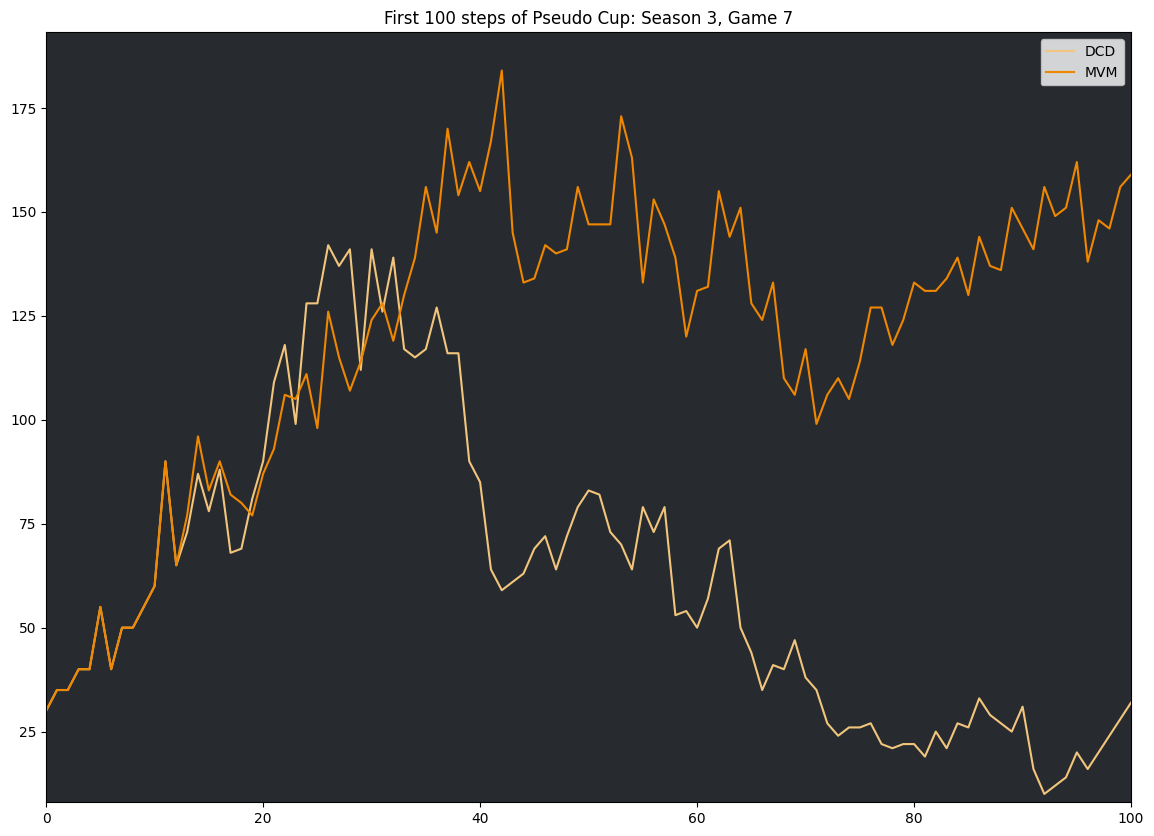

In [22]:
t1n = last_game['team1Name']
t1a = last_game['team1Abbr']
t1c = last_game['team1Color']

t2n = last_game['team2Name']
t2a = last_game['team2Abbr']
t2c = last_game['team2Color']

s1 = [d['liveCells1'] for d in inst.live_counts]
s2 = [d['liveCells2'] for d in inst.live_counts]

x = range(0, len(s1))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

ax.set_xlim(0, N)
ax.set_ylim(0.80*min(min(s1), min(s2)), 1.05*max(max(s1), max(s2)))

ax.plot(x, s1, label = t1a, color = t1c)
ax.plot(x, s2, label = t2a, color = t2c)

ax.set_title(f"First 100 steps of Pseudo Cup: Season {SEASON0+1}, Game {last_day}")

ax.set_facecolor(GOLLY_GRAY)
ax.legend()
plt.show()

Now we're ready to run the simulation until it completes.

In [23]:
last_game['generations']

2025

This time around, construct a Pseudo GOL object that has `halt = True`. This assembles a game of life object with a boolean, `running`, that is set to True initially. This boolean is only set to false when the game of life is finished and one of the teams has achieved a victory condition.

In [24]:
inst = PseudoGOL_Instrumented(
    s1=ic1,
    s2=ic2,
    rows=100,
    columns=120,
    halt=True,
)

print(inst.running)

True


In [25]:
#########################################
############### EXPENSIVE ###############
#########################################

N = 0

tic = time.time()
while inst.running:
    N += 1
    inst.next_step()
toc = time.time()
diff = toc-tic

print(f"{N} steps took {diff:0.2f} s")

2025 steps took 31.78 s


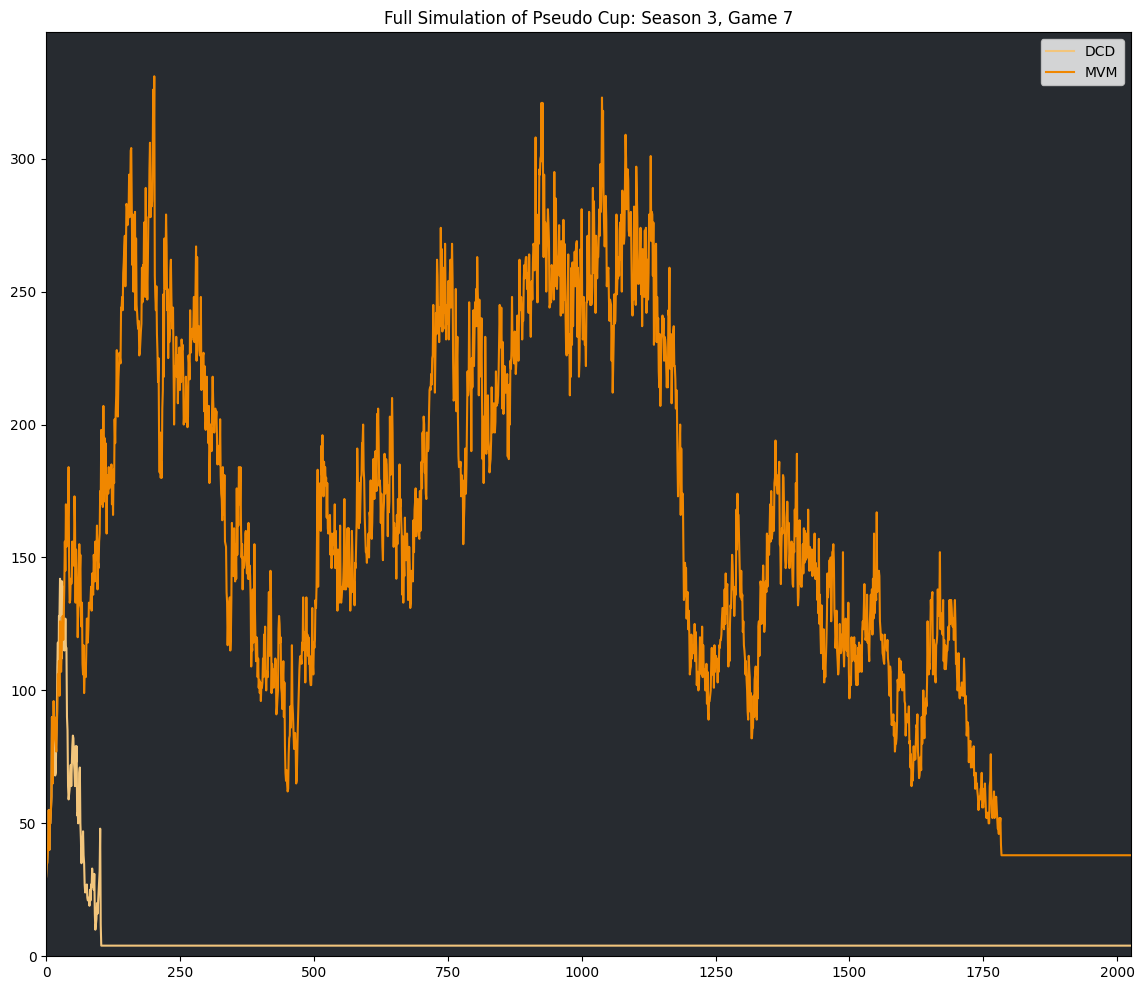

In [26]:
t1n = last_game['team1Name']
t1a = last_game['team1Abbr']
t1c = last_game['team1Color']

t2n = last_game['team2Name']
t2a = last_game['team2Abbr']
t2c = last_game['team2Color']

s1 = [d['liveCells1'] for d in inst.live_counts]
s2 = [d['liveCells2'] for d in inst.live_counts]

x = range(0, len(s1))

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

ax.set_xlim(0, len(x))
ax.set_ylim(0, 1.05*max(max(s1), max(s2)))
#ax.set_xlim(500, len(x))
#ax.set_ylim(50, 300)

ax.plot(x, s1, label = t1a, color = t1c)
ax.plot(x, s2, label = t2a, color = t2c)

ax.set_title(f"Full Simulation of Pseudo Cup: Season {SEASON0+1}, Game {last_day}")

ax.set_facecolor(GOLLY_GRAY)
ax.legend()
plt.show()

## Instrumenting the Stopping Criteria

The next thing we want to look at is the the stopping criteria.

To do this, we create a new instrumented class, that looks similar to the prior one, but this time it extends a hook function that was added where the Game of Life checks the stopping criteria. This will allow us visibility into what was happening with the stopping criteria during the match.

In [29]:
# NOTE: Must match the function used by PseudoGOL, or its parent HellmouthGOL
SMOL = 1e-12
def _diff(a, b):
    return (abs(b - a) / abs(a + SMOL))

In [30]:
victory = []
stopping_criteria1 = []
stopping_criteria2 = []
for d in inst.live_counts:
    if len(d['last3']) < 3 or d['last3'] == [0, 0, 0]:
        victory.append(0)
        stopping_criteria1.append(0)
        stopping_criteria2.append(0)
    else:
        last3_0 = d['last3'][0]
        last3_1 = d['last3'][1]
        last3_2 = d['last3'][2]
        victory.append(last3_0)
        stopping_criteria1.append(_diff(last3_0, last3_1))
        stopping_criteria2.append(_diff(last3_1, last3_2))

In [31]:
print(len(s1))
print(len(x))
print(len(stopping_criteria1))

2026
2026
2026


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/2968091076.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


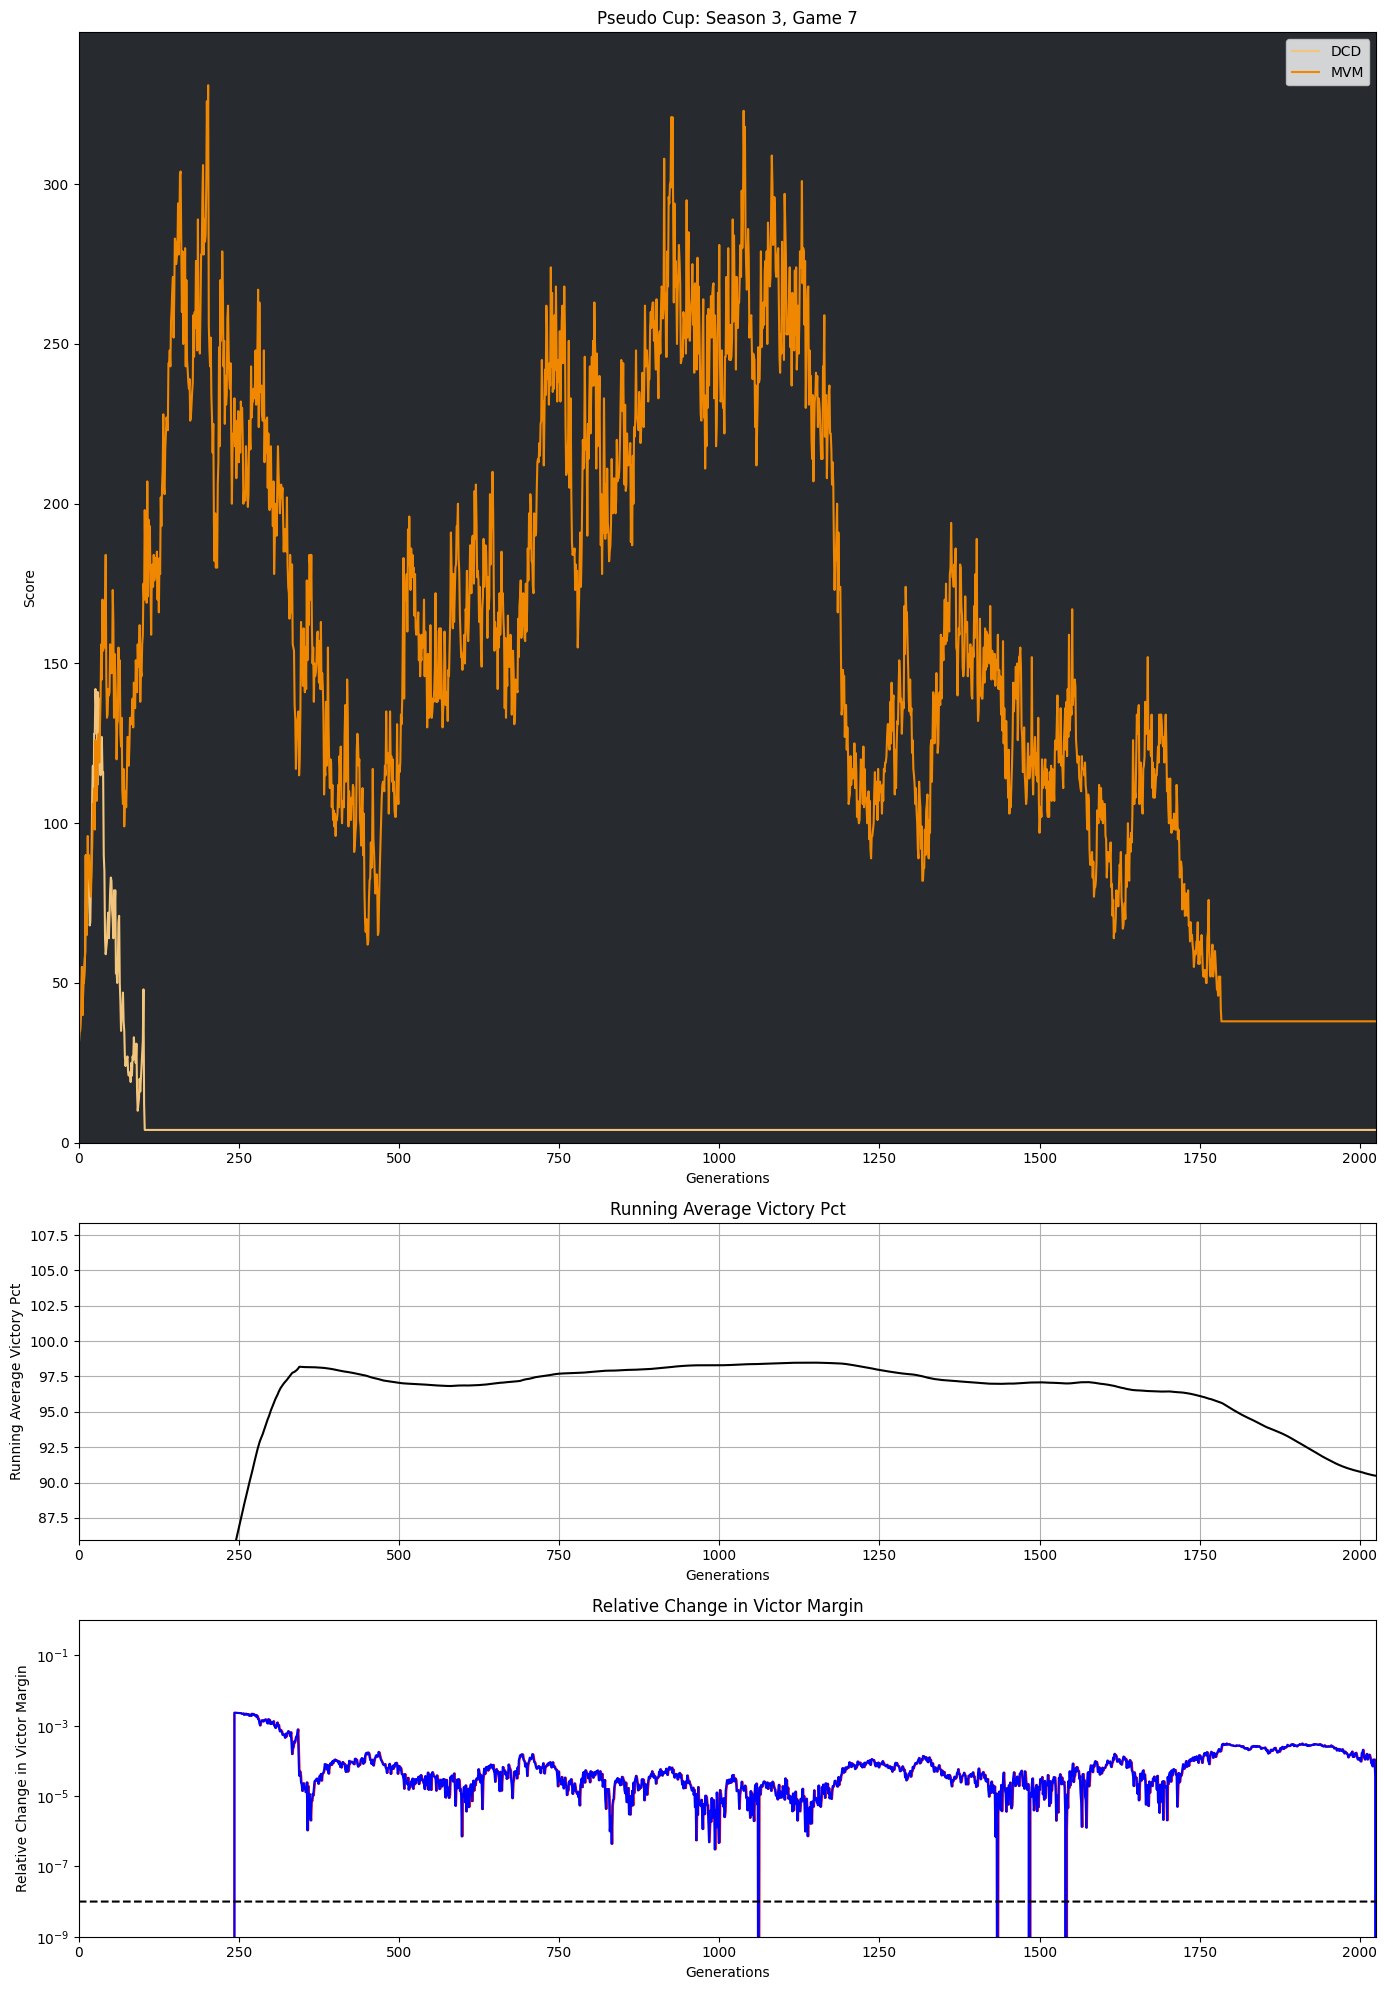

In [35]:
t1n = last_game['team1Name']
t1a = last_game['team1Abbr']
t1c = last_game['team1Color']

t2n = last_game['team2Name']
t2a = last_game['team2Abbr']
t2c = last_game['team2Color']

s1 = [d['liveCells1'] for d in inst.live_counts]
s2 = [d['liveCells2'] for d in inst.live_counts]

x = range(0, len(s1))

fig, axes = plt.subplots(1, 1, figsize=(14, 20))

ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)
ax2 = plt.subplot2grid((5,1),(3,0))
ax3 = plt.subplot2grid((5,1),(4,0))

t0 = 0
#t0 = 500

# ---------

ax1.set_xlim(t0, len(x))

# if t0 = 0
ax1.set_ylim(0, 1.05*max(max(s1), max(s2)))
# if t0 = 500
#ax1.set_ylim(50, 300)

ax1.plot(x, s1, label = t1a, color = t1c)
ax1.plot(x, s2, label = t2a, color = t2c)

ax1.set_title(f'Pseudo Cup: Season {SEASON0+1}, Game {last_day}')
ax1.set_xlabel('Generations')
ax1.set_ylabel('Score')

# ---------
# victory pct

ax2.set_xlim(t0, len(x))
ax2.set_ylim(1e-9, 1)

ax2.plot(x, victory, '-k')

ax2.set_ylim(0.95*min(victory[300:]), 1.1*max(victory[300:]))
ax2.grid('on')

ax2.set_title('Running Average Victory Pct')
ax2.set_xlabel('Generations')
ax2.set_ylabel('Running Average Victory Pct')

# ---------
# rel diff victory

ax3.set_xlim(t0, len(x))
ax3.set_ylim(1e-9, 1)

ax3.semilogy(x, stopping_criteria1, '-r')
ax3.semilogy(x, stopping_criteria2, '-b')
ax3.semilogy(x, [1e-8,]*len(x), '--k')

#ax3.set_title('Change in Mean Square Live Cells')
ax3.set_title('Relative Change in Victor Margin')
ax3.set_xlabel('Generations')
#ax3.set_ylabel('Relative Change in Mean Square Live Cells')
ax3.set_ylabel('Relative Change in Victor Margin')

# ----------

ax1.set_facecolor(GOLLY_GRAY)
ax1.legend()

fig.tight_layout()
plt.show()

## Functionalizing It

If we're going to analyze a bunch of games, we should do a few things:

* rewrite this as a function, starting with the game JSON and ending with plots and other useful info
* parameterize the variables and labels and such
* add ability to load and dump games that have already been simulated - giant pool, indexed by UUID, probably

In [36]:
# NOTE: Must match the function used by PseudoGOL, or its parent HellmouthGOL
def _pseudo_diff(a, b):
    SMOL = 1e-12
    return (abs(b - a) / abs(a + SMOL))

In [37]:
def get_pseudo_cup_miniseason(season0):
    """Get the miniseason (list of days, one game per day) for the Pseudo Cup playoffs"""
    cup = 'pseudo'
    post_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{season0}', 'postseason.json')
    if not os.path.exists(post_file):
        raise Exception(f"Error: could not find file {post_file}")
    with open(post_file, 'r') as f:
        post = json.load(f)
    return post

In [38]:
def make_pseudo_cup_plot(game_json):
    ic1 = game_json['map']['initialConditions1']
    ic2 = game_json['map']['initialConditions2']
    descr = game_json['description']

    inst = PseudoGOL_Instrumented(
        s1=ic1,
        s2=ic2,
        rows=100,
        columns=120,
        halt=True,
    )
    
    print(f"Starting simulation of game: {descr}")
    
    N = 0
    tic = time.time()
    while inst.running:
        N += 1
        inst.next_step()
    toc = time.time()
    diff = toc-tic

    print(f"{N} steps took {diff:0.2f} s")
    
    
    t1n = game_json['team1Name']
    t1a = game_json['team1Abbr']
    t1c = game_json['team1Color']
    t1s = game_json['team1Score']

    t2n = game_json['team2Name']
    t2a = game_json['team2Abbr']
    t2c = game_json['team2Color']
    t2s = game_json['team2Score']

    descr = game_json['description']

    s1 = [d['liveCells1'] for d in inst.live_counts]
    s2 = [d['liveCells2'] for d in inst.live_counts]
    
    
    victory = []
    stopping_criteria1 = []
    stopping_criteria2 = []
    for d in inst.live_counts:
        if len(d['last3']) < 3 or d['last3'] == [0, 0, 0]:
            victory.append(0)
            stopping_criteria1.append(0)
            stopping_criteria2.append(0)
        else:
            last3_0 = d['last3'][0]
            last3_1 = d['last3'][1]
            last3_2 = d['last3'][2]
            victory.append(last3_0)
            stopping_criteria1.append(_diff(last3_0, last3_1))
            stopping_criteria2.append(_diff(last3_1, last3_2))
    
    
    x = range(0, len(s1))

    fig, axes = plt.subplots(1, 1, figsize=(14, 20))

    ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)
    ax2 = plt.subplot2grid((5,1),(3,0))
    ax3 = plt.subplot2grid((5,1),(4,0))

    t0 = 0
    #t0 = 500

    # ---------

    ax1.set_xlim(t0, len(x))

    # if t0 = 0
    ax1.set_ylim(0, 1.05*max(max(s1), max(s2)))
    # if t0 = 500
    #ax1.set_ylim(50, 300)

    ax1.plot(x, s1, label = t1n + f"({t1s})", color = t1c)
    ax1.plot(x, s2, label = t2n + f"({t2s})", color = t2c)

    ax1.set_title(f'{descr}: {t1n} vs. {t2n}\nScore vs Generations')
    ax1.set_xlabel('Generations')
    ax1.set_ylabel('Score')

    # ---------
    # victory pct

    ax2.set_xlim(t0, len(x))
    ax2.set_ylim(1e-9, 1)

    ax2.plot(x, victory, '-k')

    ax2.set_ylim(0.95*min(victory[300:]), 1.1*max(victory[300:]))
    ax2.grid('on')

    ax2.set_title('Running Average Victory Pct')
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Running Average Victory Pct')


    # ---------
    # rel diff victory

    ax3.set_xlim(t0, len(x))
    ax3.set_ylim(1e-9, 1)

    ax3.semilogy(x, stopping_criteria1, '-r')
    ax3.semilogy(x, stopping_criteria2, '-b')
    ax3.semilogy(x, [1e-8,]*len(x), '--k')

    #ax3.set_title('Change in Mean Square Live Cells')
    ax3.set_title('Relative Change in Victory Pct')
    ax3.set_xlabel('Generations')
    #ax3.set_ylabel('Relative Change in Mean Square Live Cells')
    ax3.set_ylabel('Relative Change in Victor Pct')
    ax3.grid('on')
    
    # ----------

    ax1.set_facecolor(GOLLY_GRAY)
    ax1.legend()

    fig.tight_layout()
    plt.show()

In [39]:
season0_post = get_pseudo_cup_miniseason(SEASON0)
pcs = season0_post['HCS']

# Game 1

Starting simulation of game: Game 1, Pseudo Cup
4509 steps took 138.61 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


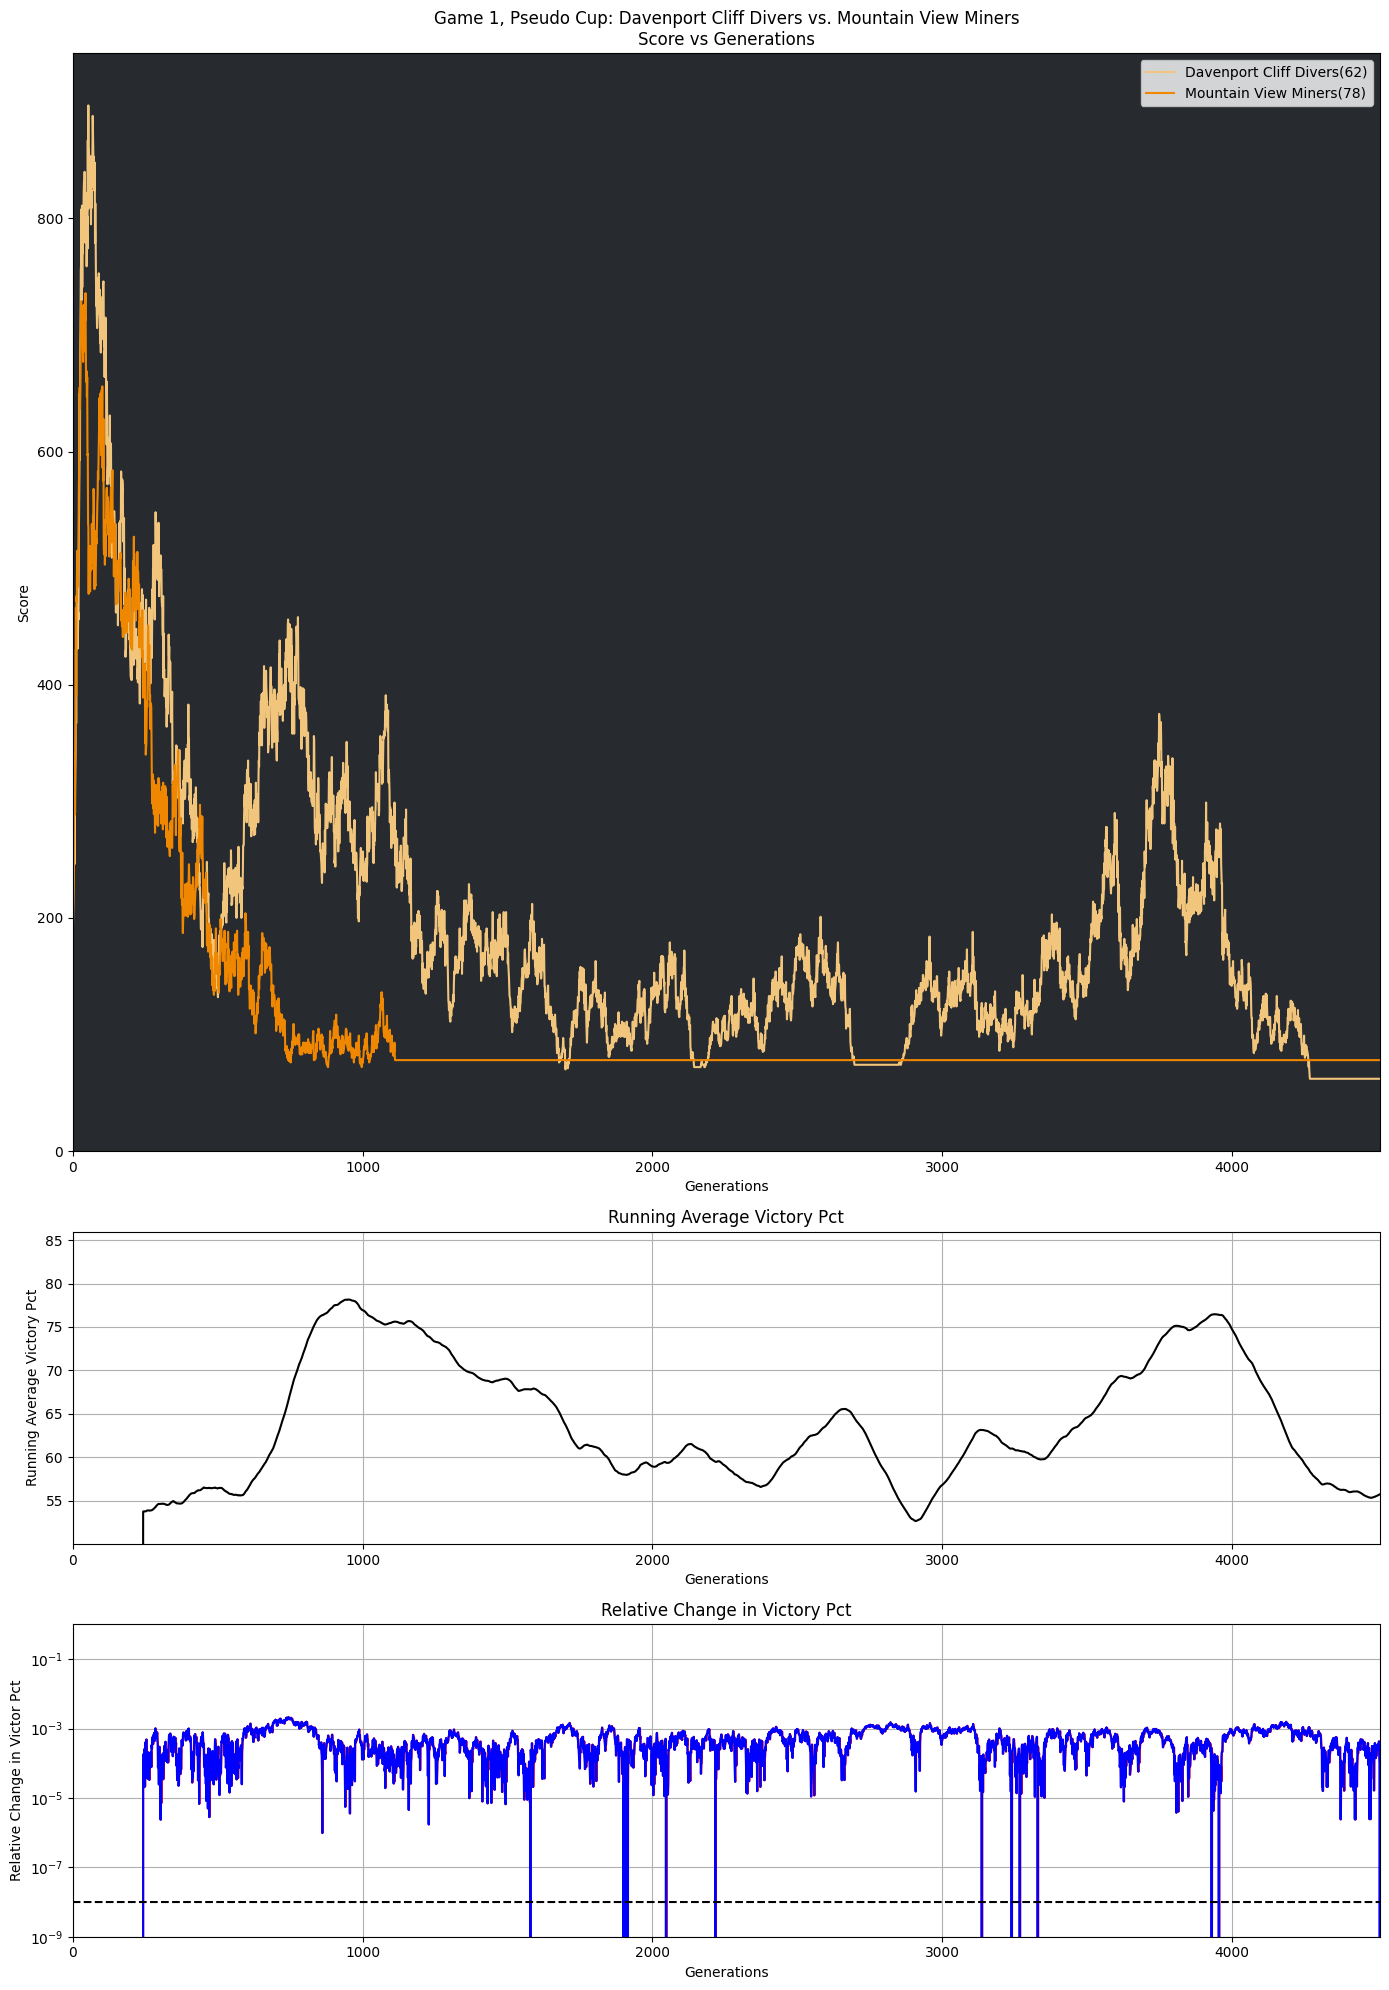

In [40]:
game1 = pcs[0][0]
make_pseudo_cup_plot(game1)

# Game 2

Starting simulation of game: Game 2, Pseudo Cup
2072 steps took 133.68 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


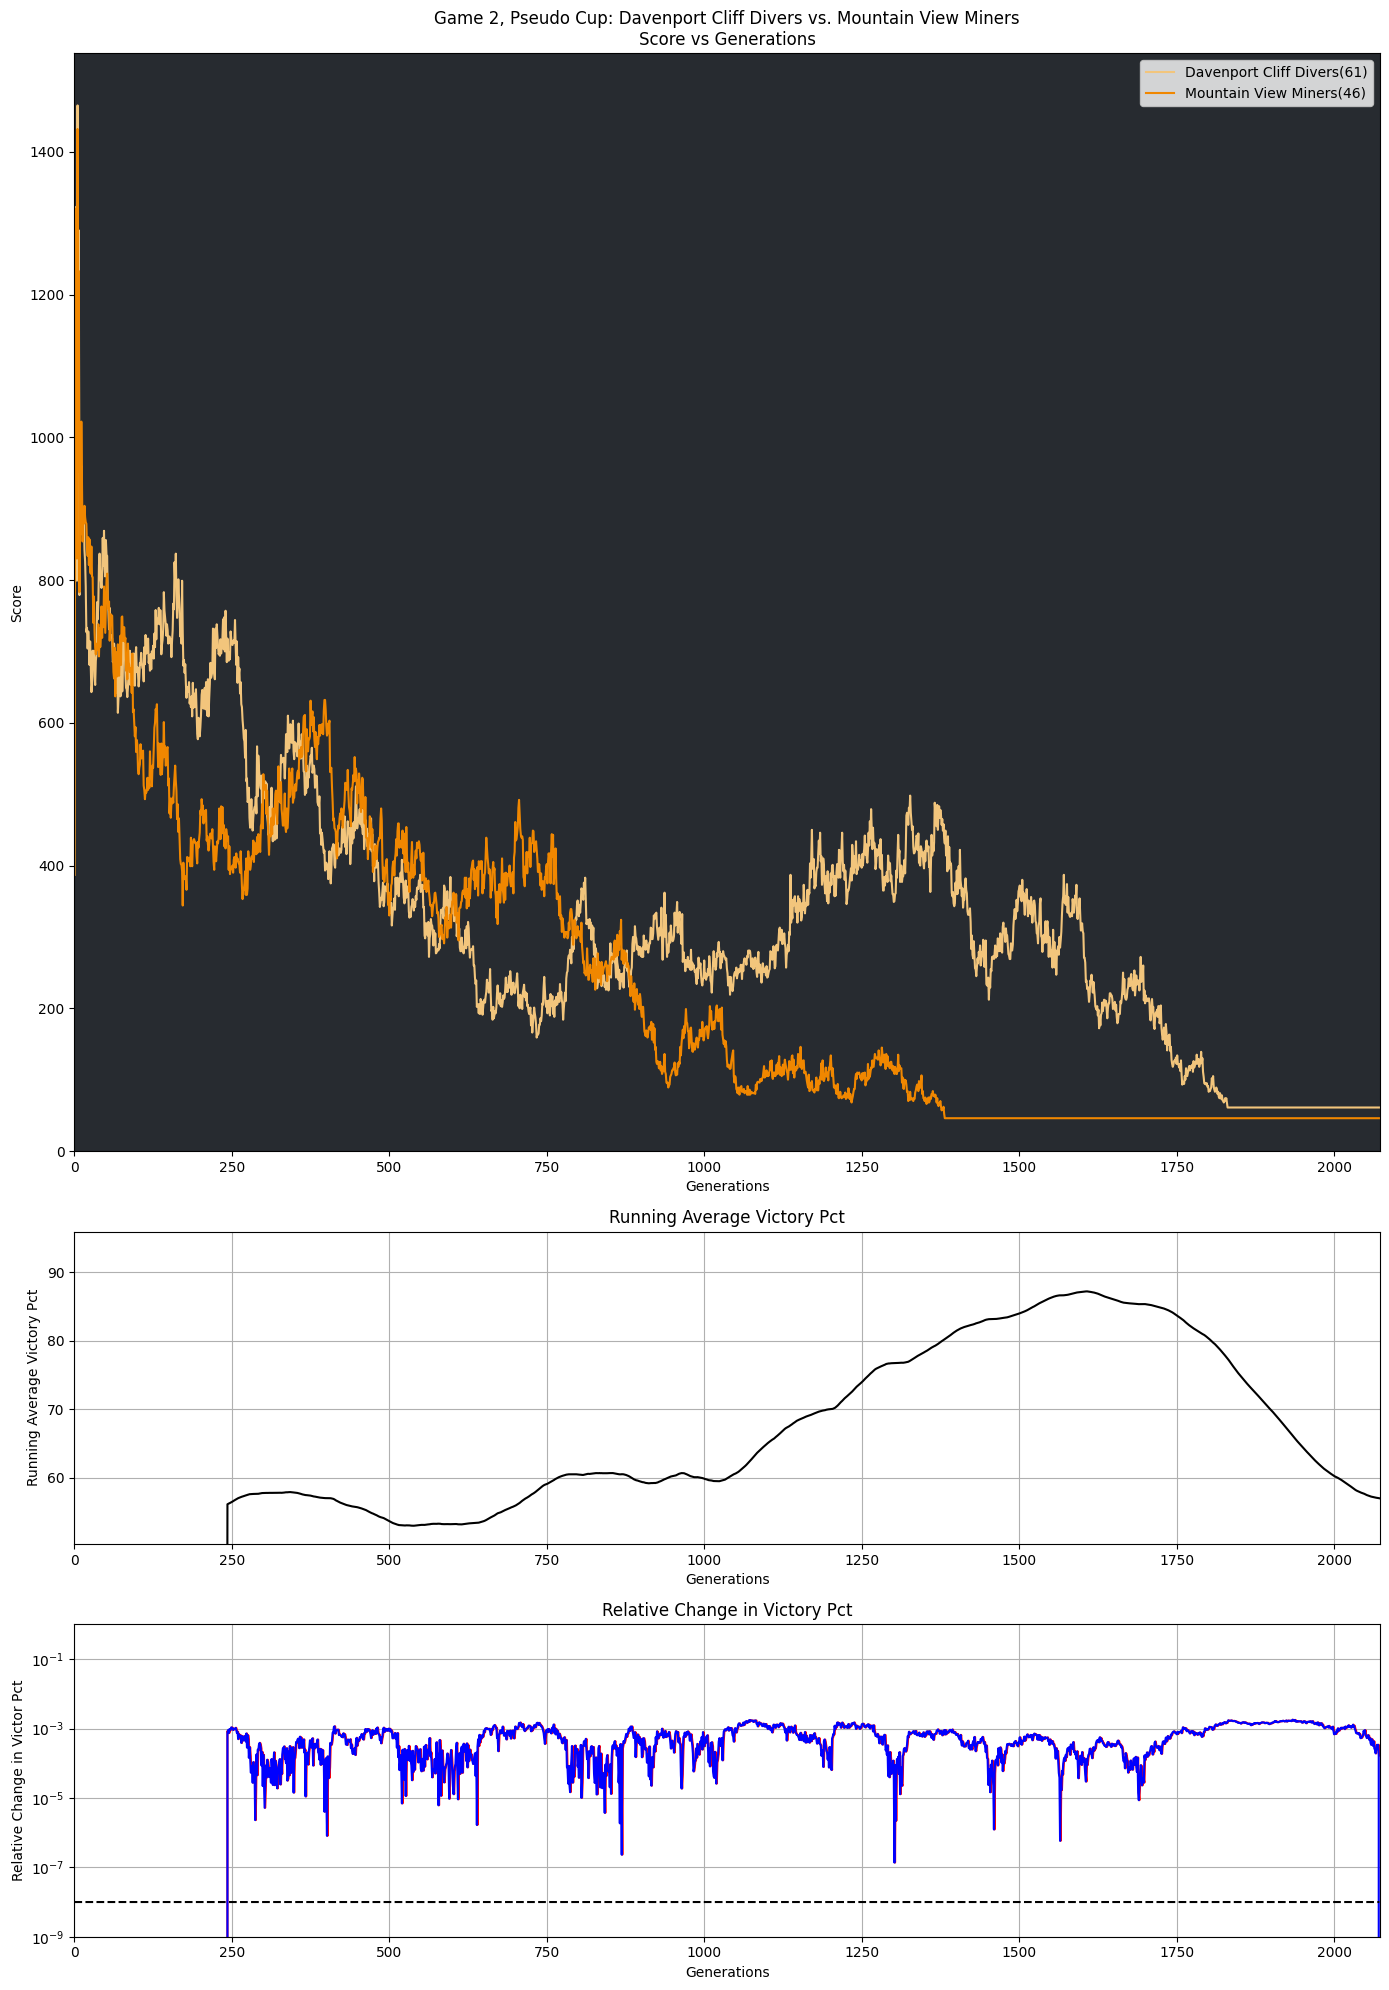

In [41]:
game2 = pcs[1][0]
make_pseudo_cup_plot(game2)

# Game 3

Starting simulation of game: Game 3, Pseudo Cup
1818 steps took 137.28 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


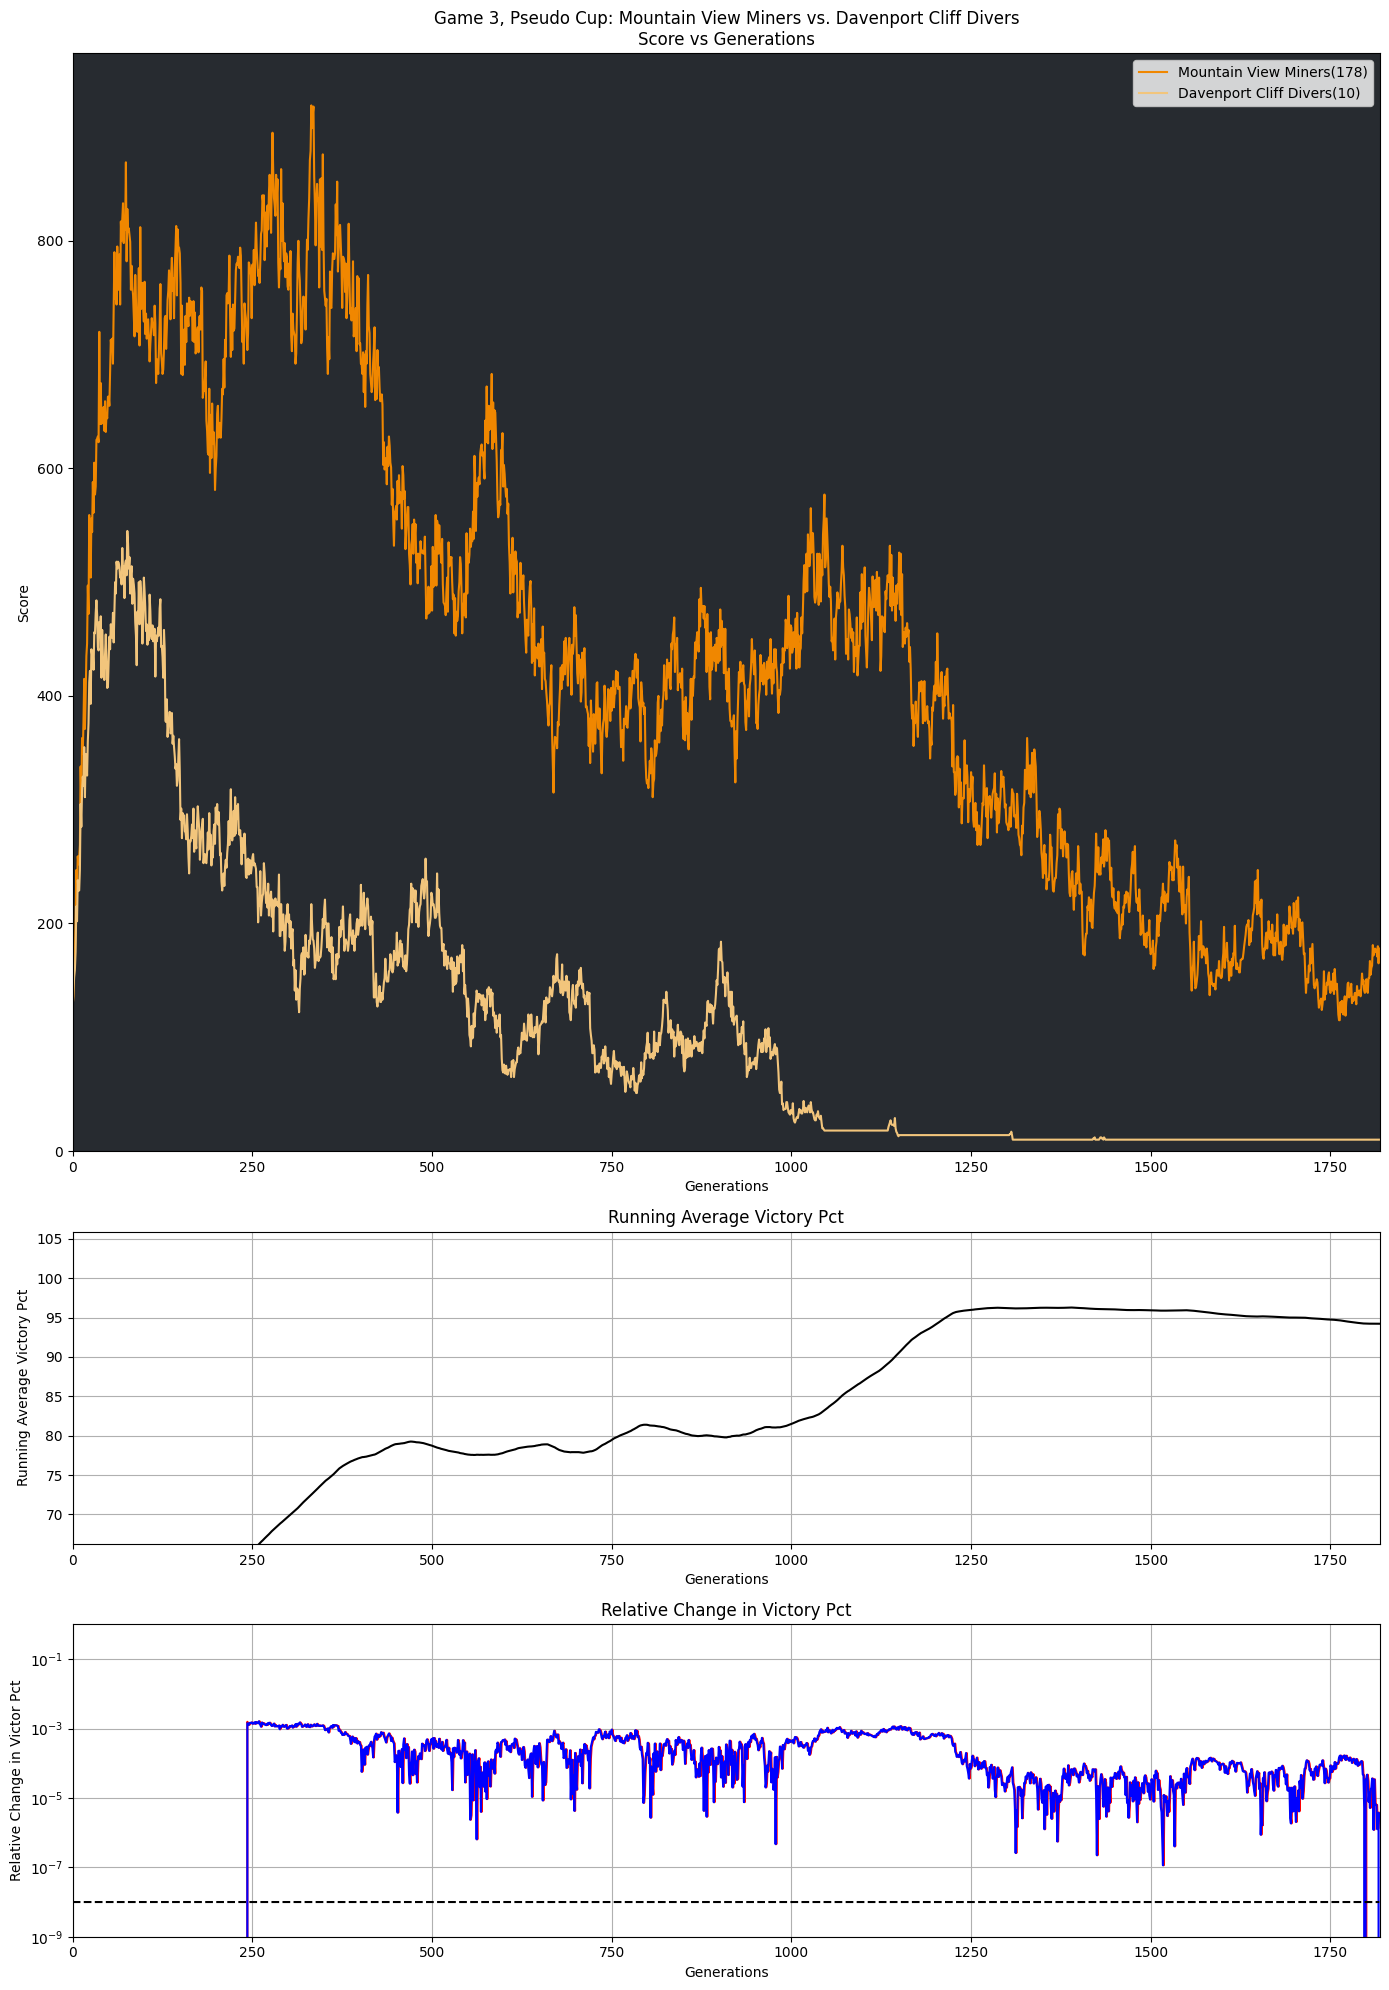

In [42]:
game3 = pcs[2][0]
make_pseudo_cup_plot(game3)

# Game 4

Starting simulation of game: Game 4, Pseudo Cup
3965 steps took 191.26 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


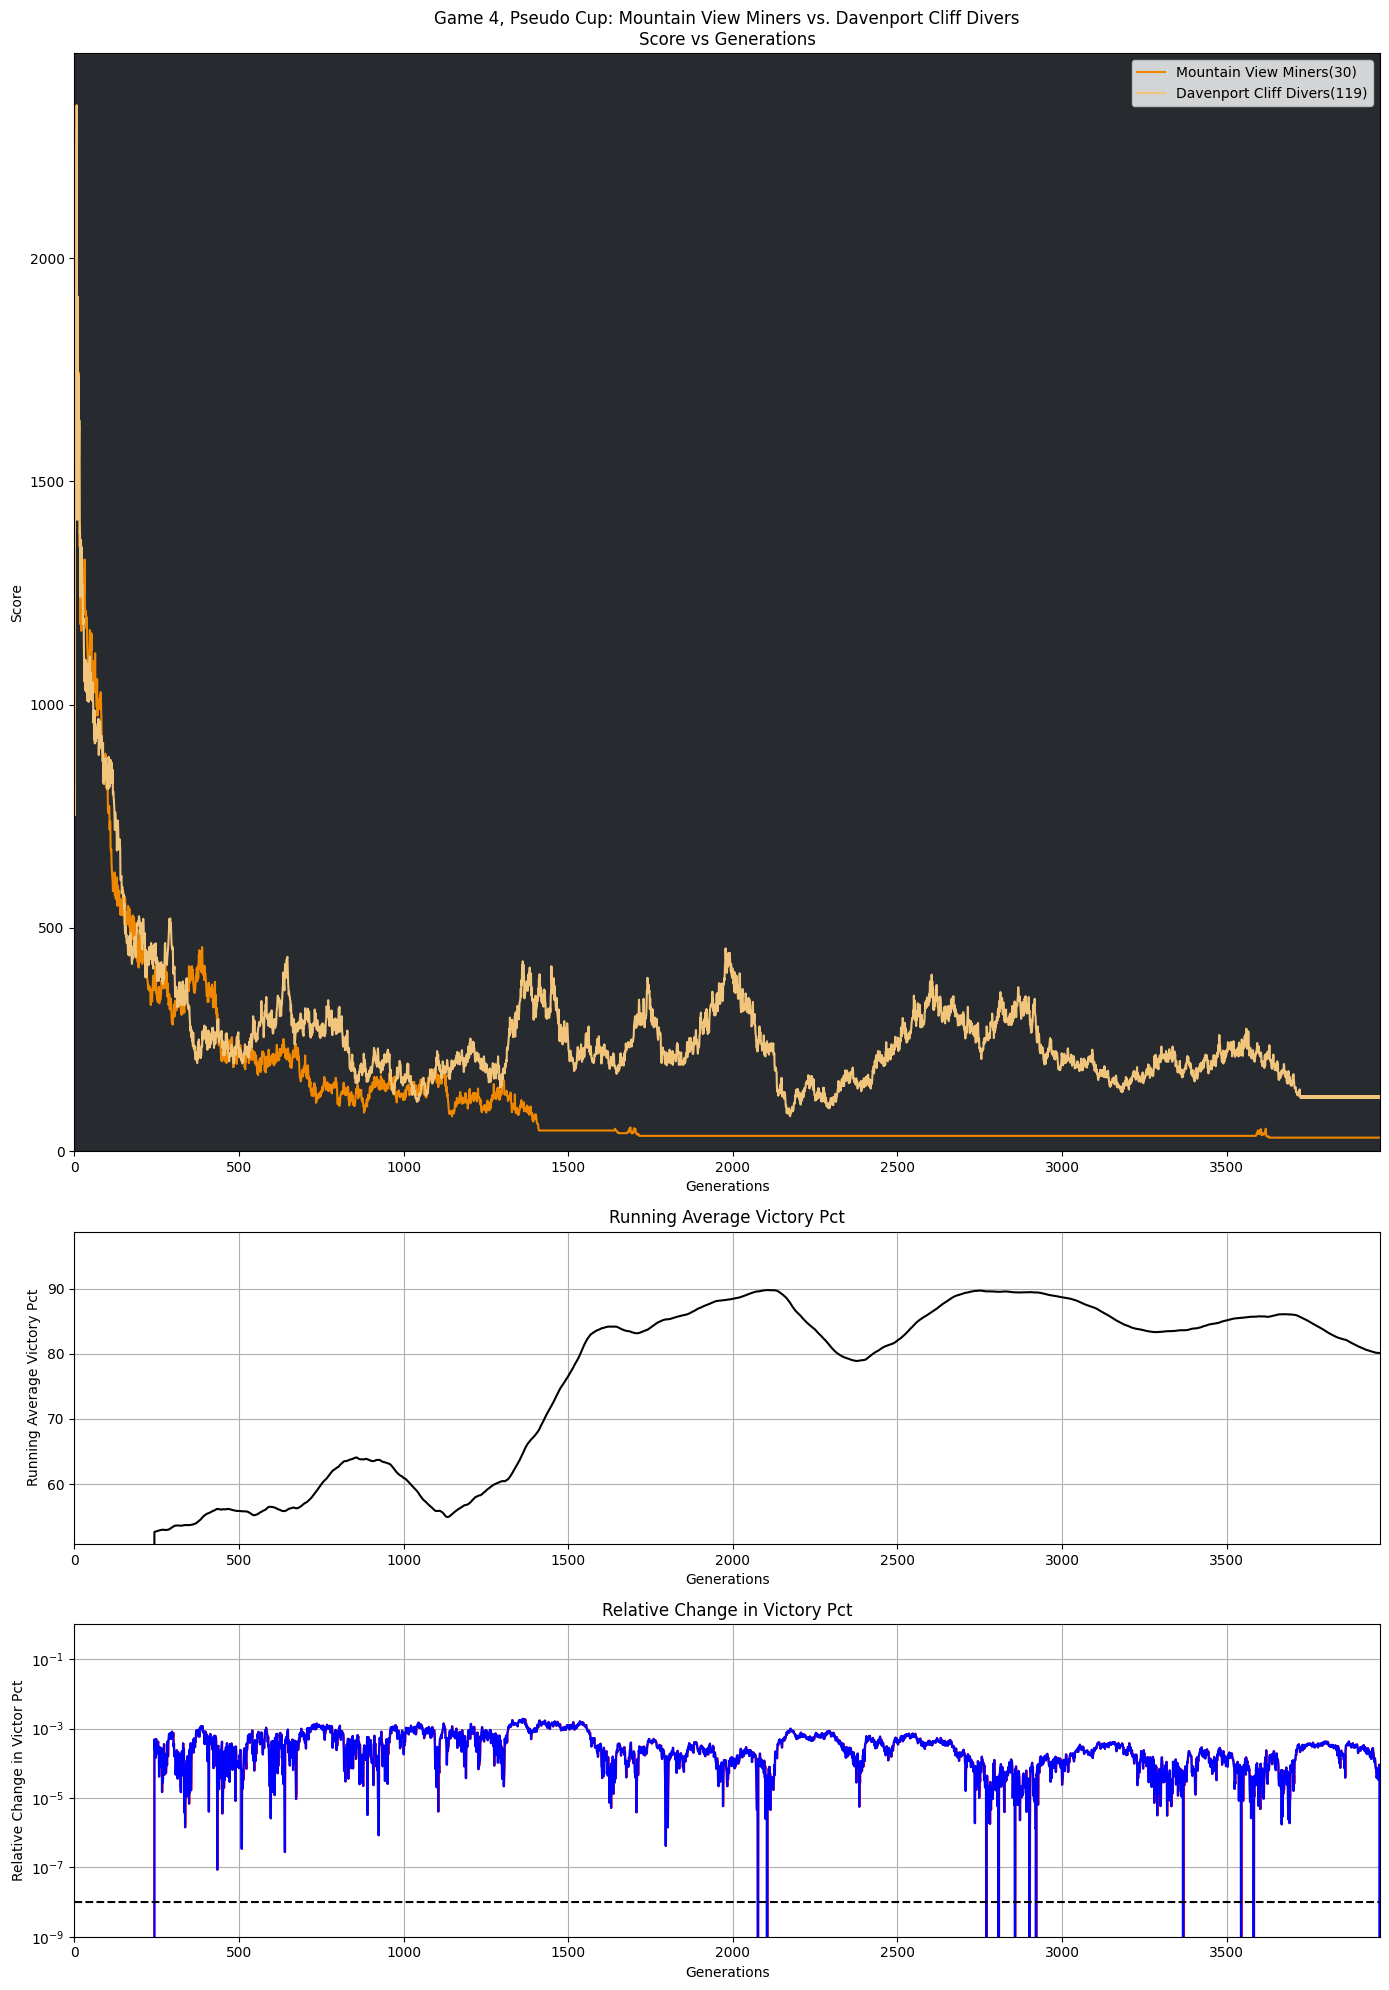

In [43]:
game4 = pcs[3][0]
make_pseudo_cup_plot(game4)

# Game 5

Starting simulation of game: Game 5, Pseudo Cup
2156 steps took 106.84 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


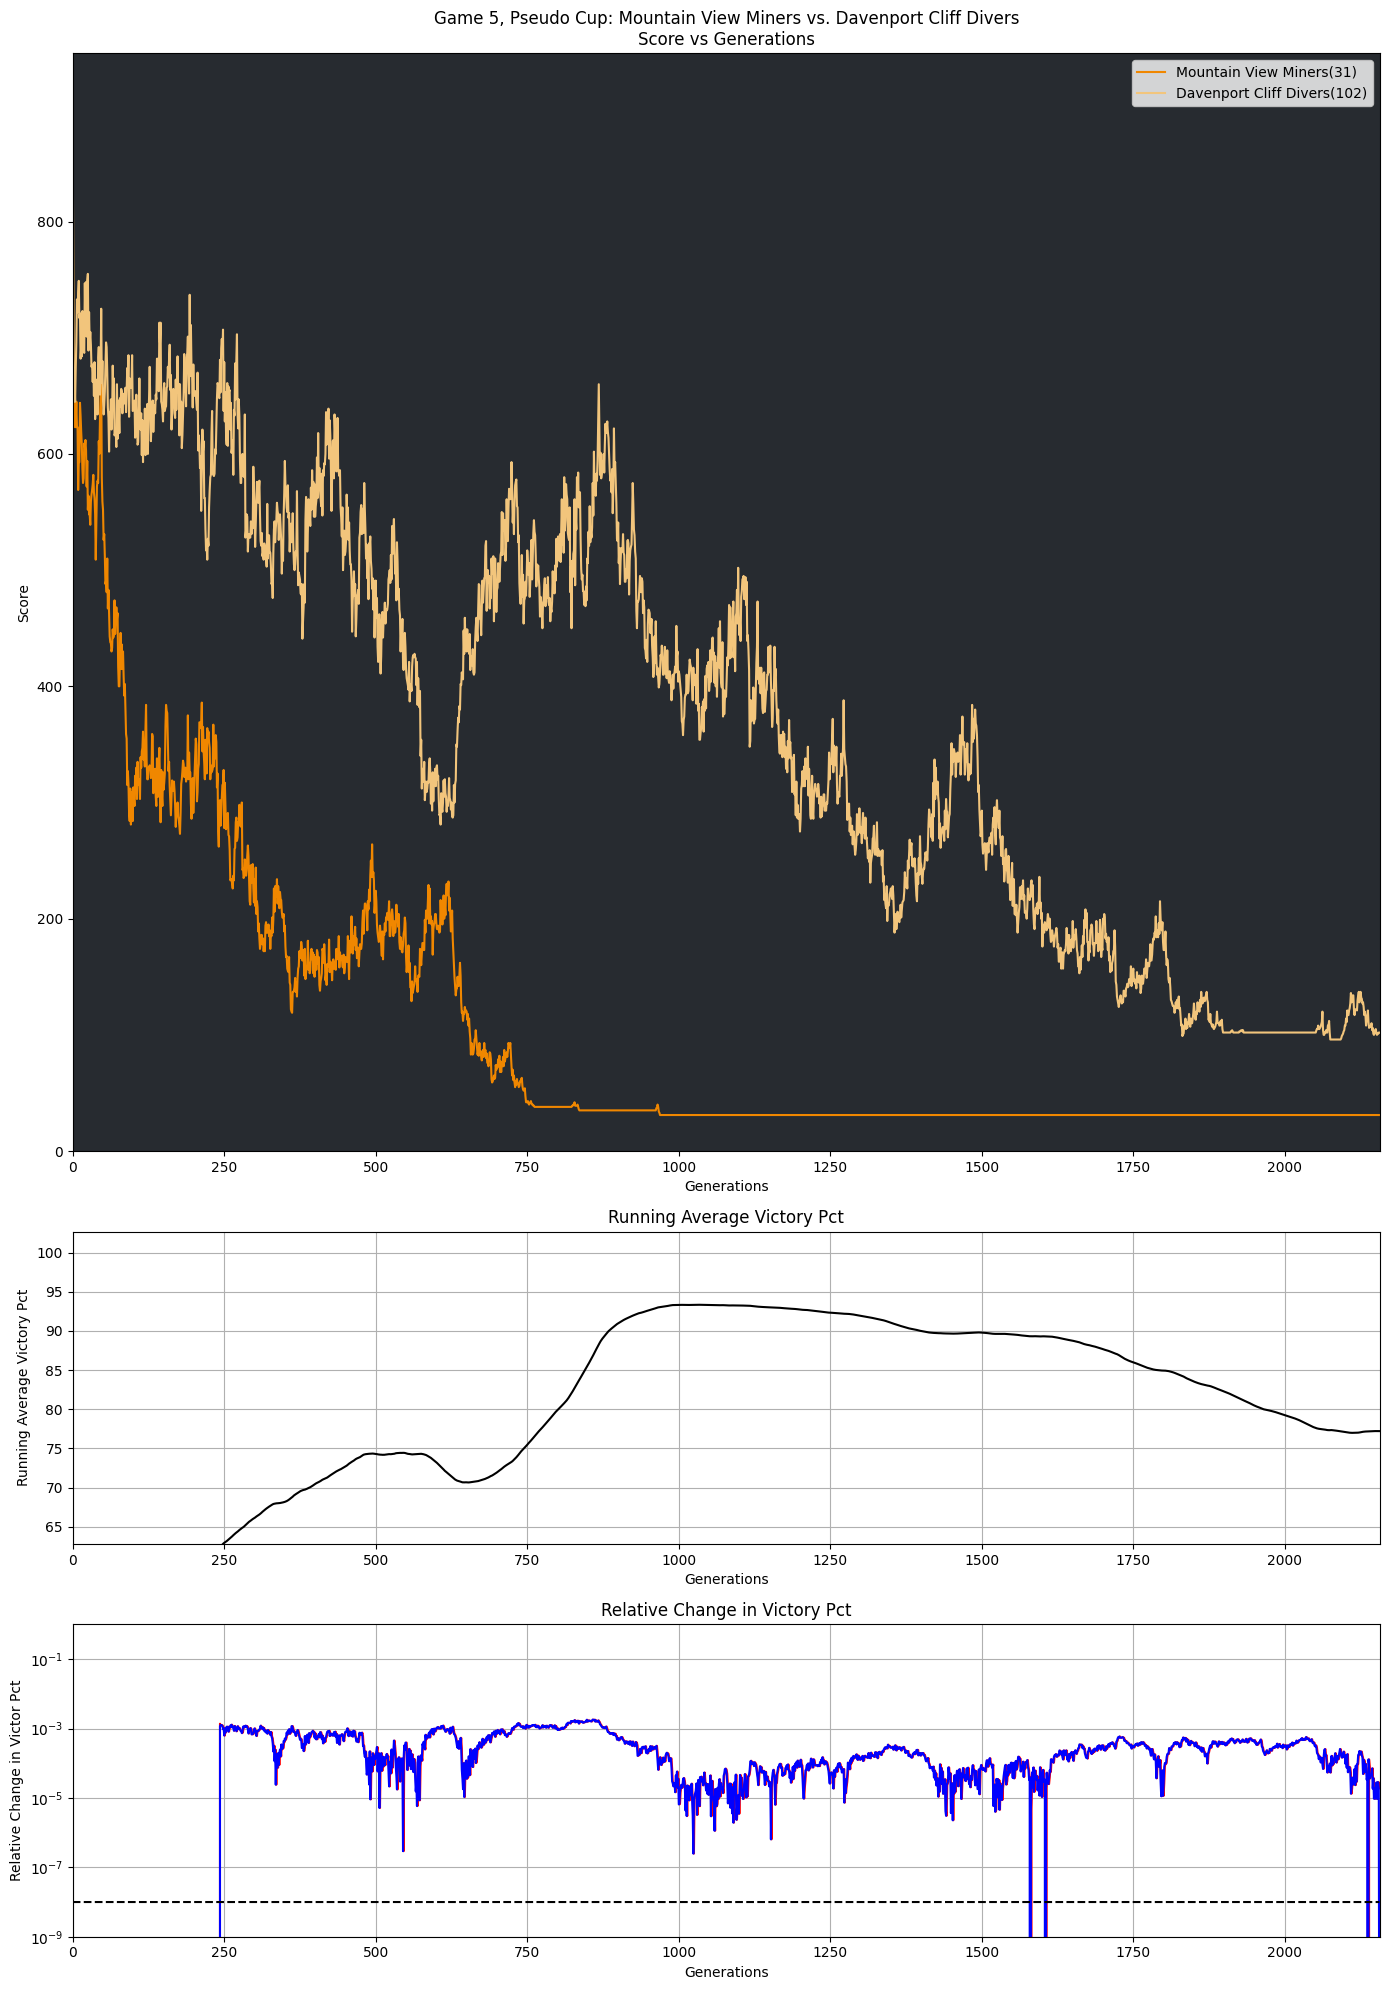

In [44]:
game5 = pcs[4][0]
make_pseudo_cup_plot(game5)

# Game 6

Starting simulation of game: Game 6, Pseudo Cup
1693 steps took 47.65 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


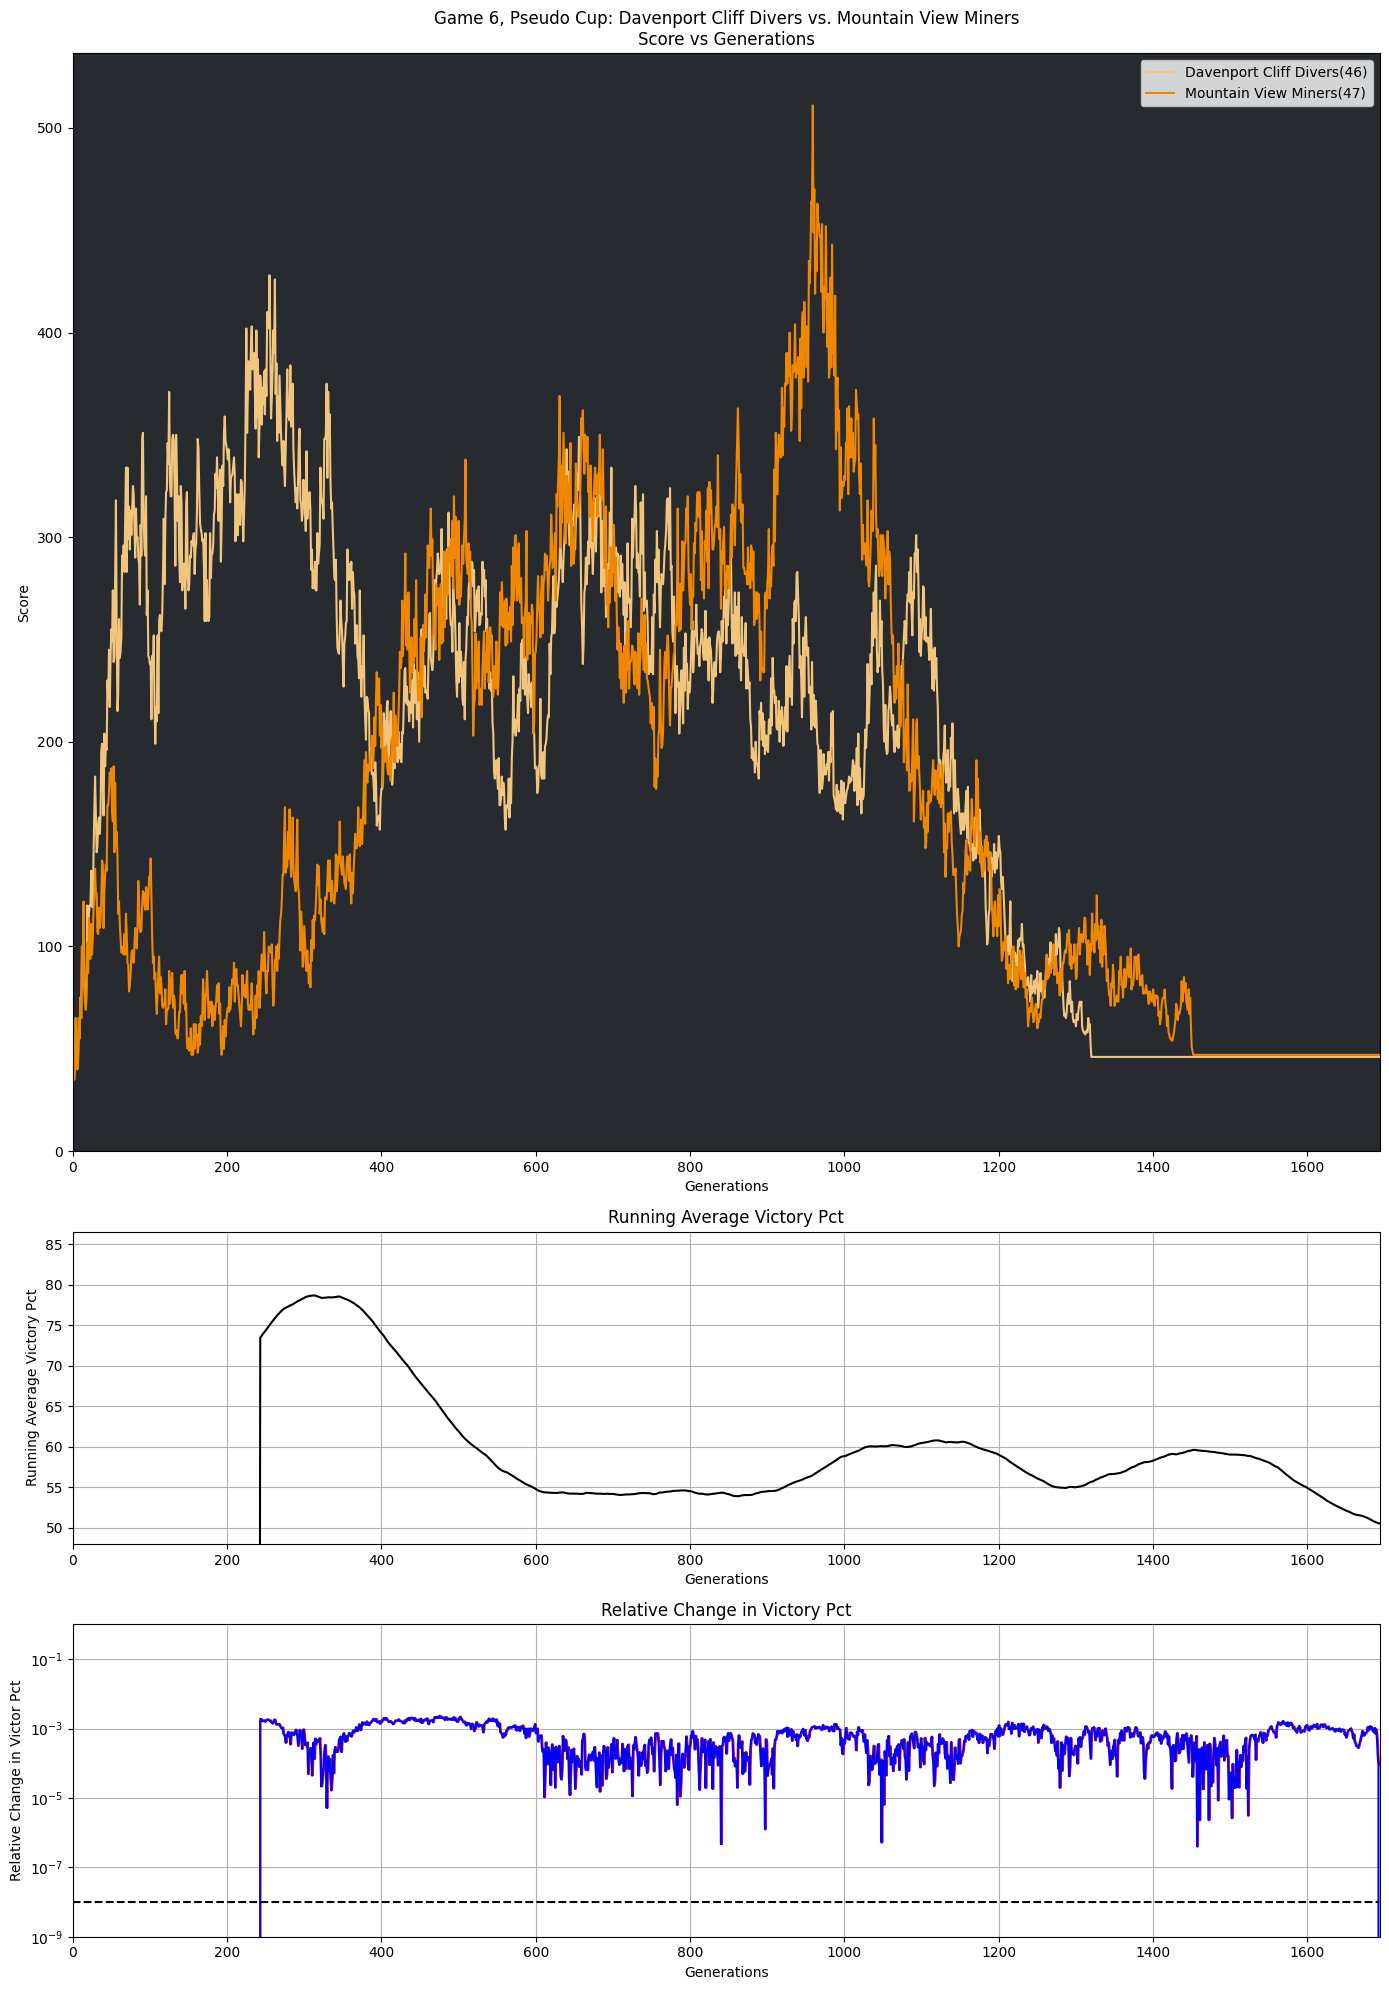

In [45]:
game6 = pcs[5][0]
make_pseudo_cup_plot(game6)

# Game 7

Starting simulation of game: Game 7, Pseudo Cup
2025 steps took 29.33 s


/var/folders/lj/h43n12kj52j8wl8rsp0vz8nw0000gn/T/ipykernel_47987/3934805338.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)


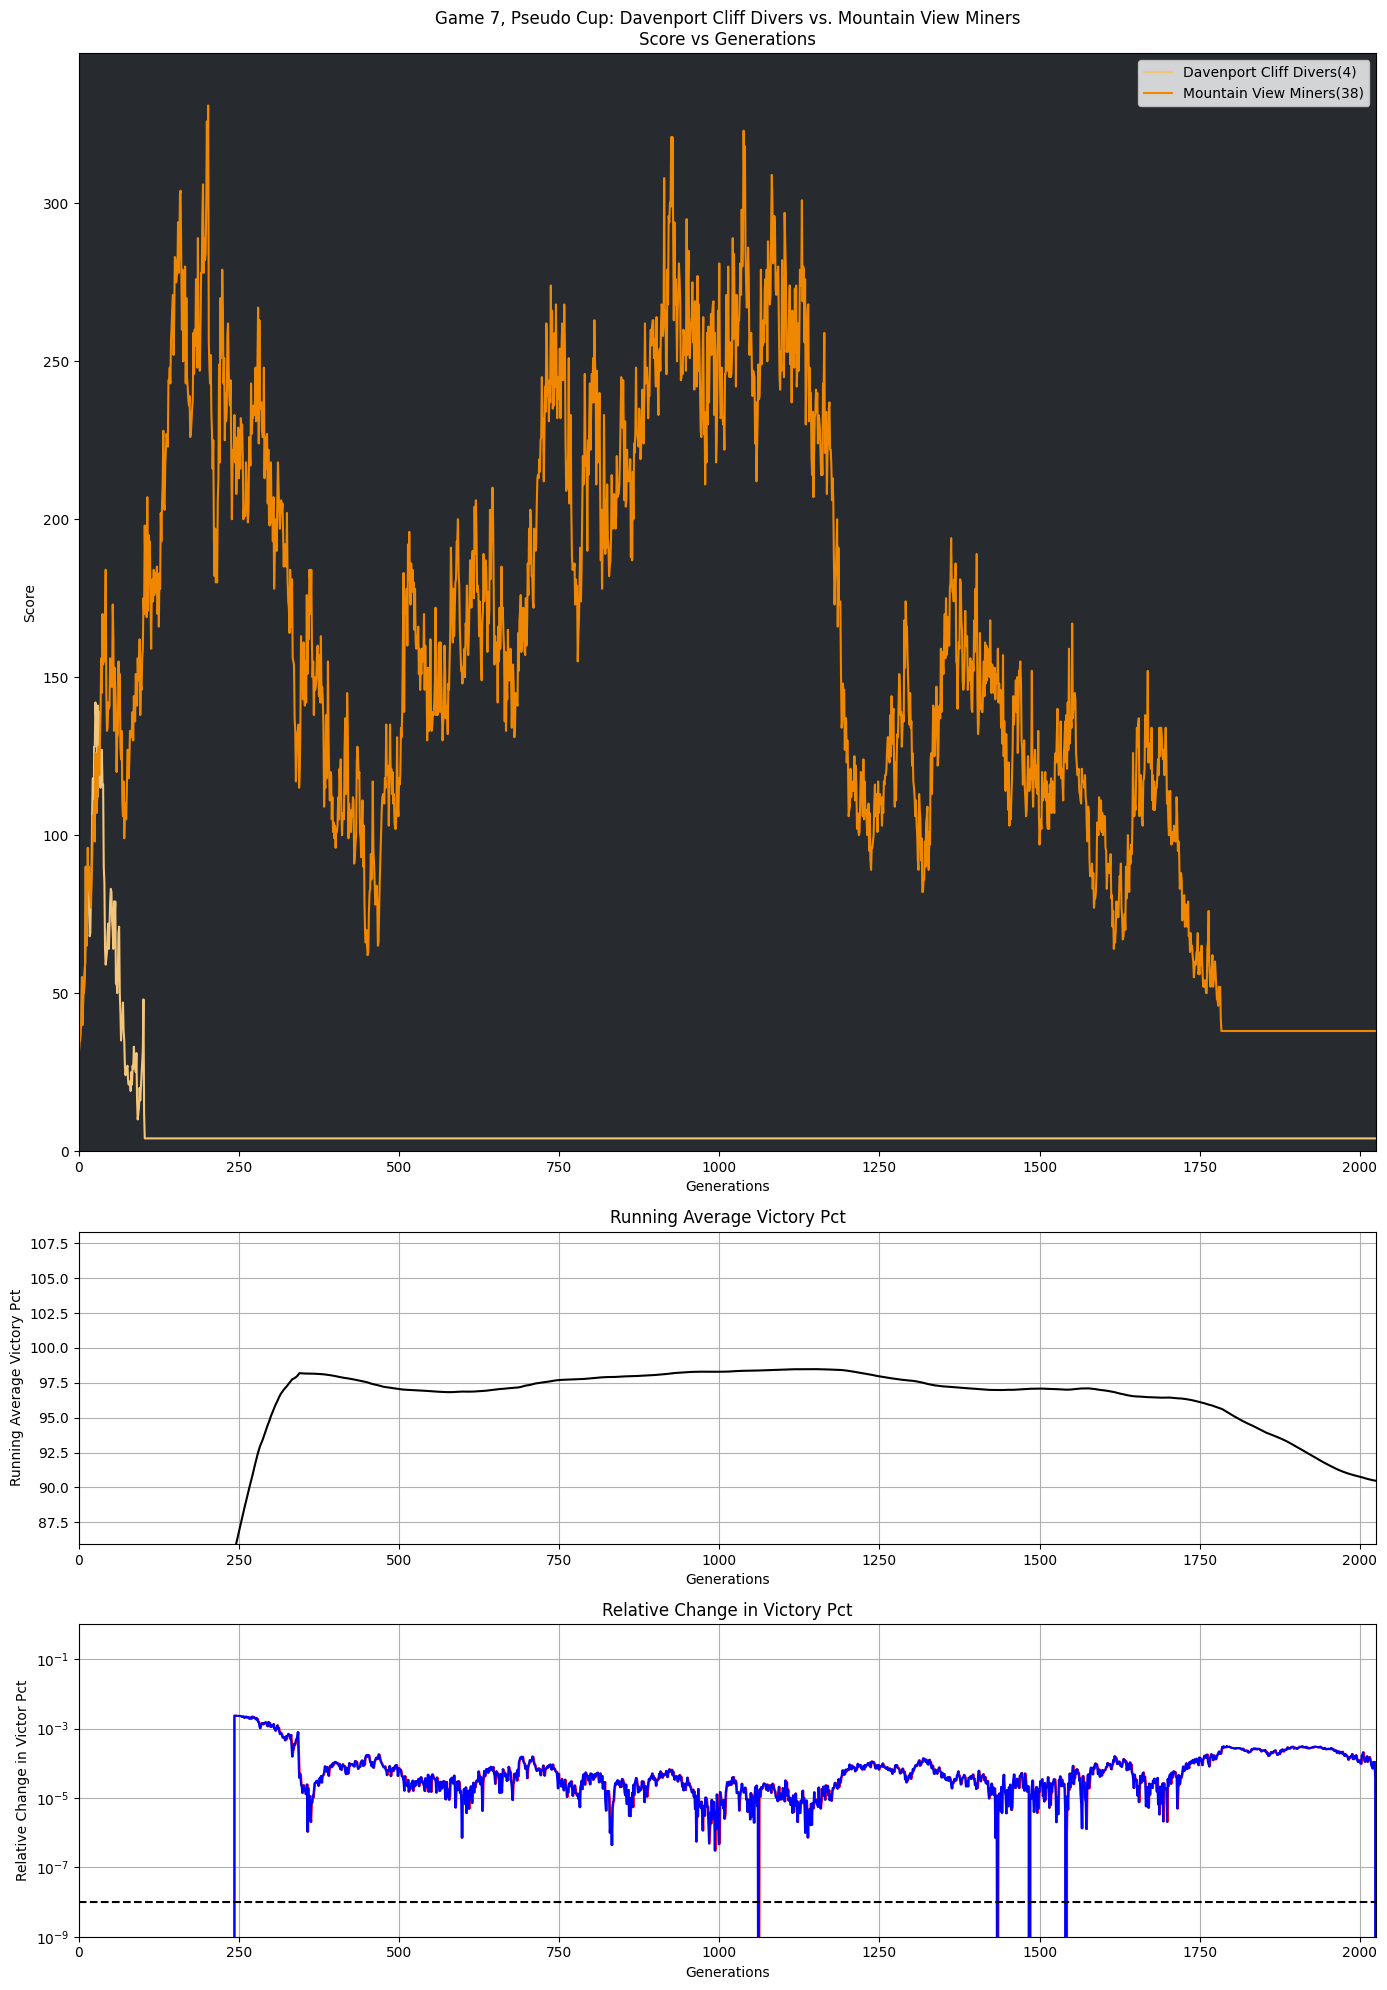

In [46]:
game7 = pcs[6][0]
make_pseudo_cup_plot(game7)